# Benchmarking Tabular ML Datasets
Thom, Jakob and Marit

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Load in Data

In [2]:
def load_df(filename, foldername='gdrive/My Drive/project/aml-2025-benchmarking-tabular-ml-datasets'):
    return pd.read_csv(f'{foldername}/{filename}', header=0)

In [3]:
!# Source - https://stackoverflow.com/a
# Posted by anarchy, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-27, License - CC BY-SA 4.0

from google.colab import drive
drive.mount('/content/gdrive/')



Mounted at /content/gdrive/


In [4]:
!pwd

/content


In [5]:
covtype_test = load_df('covtype_test.csv')
covtype_train = load_df('covtype_train.csv')
heloc_test = load_df('heloc_test.csv')
heloc_train = load_df('heloc_train.csv')
higgs_test = load_df('higgs_test.csv')
higgs_train = load_df('higgs_train.csv')

# Make all target columns have the name 'target'
covtype_train.rename(columns={'Cover_Type' : 'label'}, inplace=True)
heloc_train.rename(columns={'RiskPerformance' : 'label'}, inplace=True)
higgs_train.rename(columns={'Label' : 'label'}, inplace=True)

In [6]:
def add_task_id(data):
    num_cols = data.shape[1]
    if 'label' in data:
        num_cols -= 1

    if num_cols == 54:
        data['task_id'] = 0 # Covtype
    elif num_cols == 23:
        data['task_id'] = 1 # Heloc
    elif num_cols == 31:
        data['task_id'] = 2 # Higgs
    else:
        data['task_id'] = 3

    return data

In [7]:
covtype_train = add_task_id(covtype_train)
covtype_test = add_task_id(covtype_test)

heloc_train = add_task_id(heloc_train)
heloc_test = add_task_id(heloc_test)

higgs_train = add_task_id(higgs_train)
higgs_test = add_task_id(higgs_test)

In [8]:
tables_test = [covtype_test, heloc_test, higgs_test]
tables_train = [covtype_train, heloc_train, higgs_train]
names = ['CoverType', 'HELOC', 'Higgs']

## Data Exploration

In [9]:
# Very general quantification of the datasets
for table, name in zip(tables_train, names):
    print(name)
    print('Number of columns:', len(table.columns))
    print('Number of rows:', len(table))
    print('Number of classes:', len(table['label'].unique()))
    print()


CoverType
Number of columns: 56
Number of rows: 58101
Number of classes: 7

HELOC
Number of columns: 25
Number of rows: 9413
Number of classes: 2

Higgs
Number of columns: 34
Number of rows: 175000
Number of classes: 2



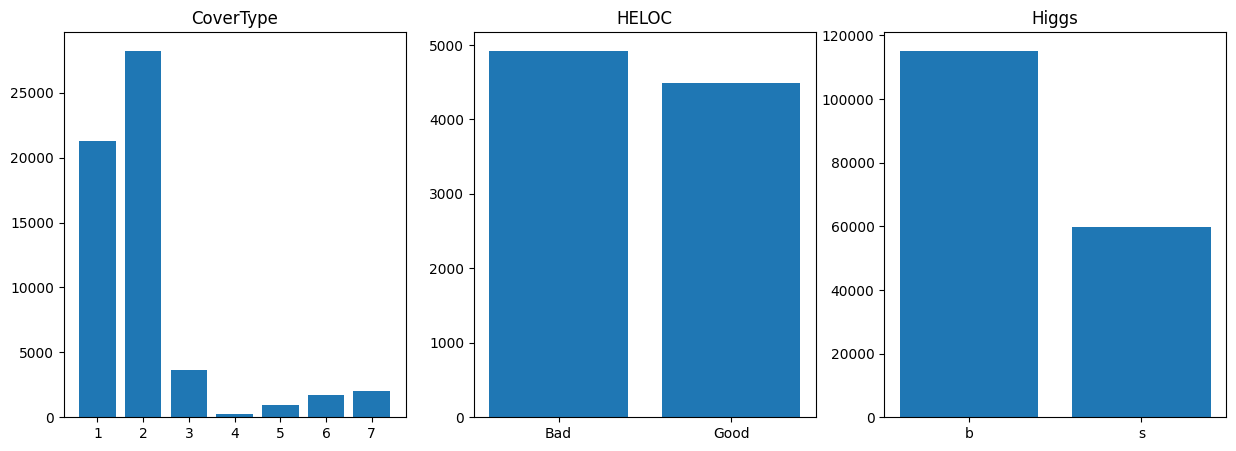

In [10]:
fig, axs = plt.subplots(nrows=1,
                        ncols=3,
                        figsize=(15,5))

for i in range(len(tables_train)):
    labels, counts = np.unique(tables_train[i]['label'], return_counts=True)
    axs[i].bar(labels, counts, align='center')
    axs[i].set_title(names[i])

# fig

## Baseline Model

In [11]:
# Heloc missing values annotated as NEGATIVE INTEGERS, will replace with NaN
heloc_numberic_cols = heloc_train.select_dtypes(include=np.number).columns
heloc_train[heloc_numberic_cols] = heloc_train[heloc_numberic_cols].where(heloc_train[heloc_numberic_cols] >= 0, other=np.nan)

In [12]:
# Higgs missing values annotated as -999.0, will replace with NaN
higgs_train = higgs_train.where(higgs_train != -999.0, other=np.nan)

In [13]:
combined_train = pd.concat([covtype_train, heloc_train, higgs_train], ignore_index = True)
combined_train['task_id'] = combined_train['task_id'].astype('category') # Has to be made a categorical feature, for the model to "catch" it

In [14]:
# Creating a unified target label column, with values from 1-11 (1-7 - Covtype, 8-9 - Heloc, 10-11 - Higgs)
combined_train.loc[combined_train['label'] == 'Bad', 'label'] = 8 # Heloc target coding
combined_train.loc[combined_train['label'] == 'Good', 'label'] = 9 # Heloc target coding

combined_train.loc[combined_train['label'] == 'b', 'label'] = 10 # Higgs target coding
combined_train.loc[combined_train['label'] == 's', 'label'] = 11 # Higgs target coding

In [25]:
# !pip install tabpfn

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tabpfn import TabPFNClassifier

# Load data
X, y = combined_train.loc[:, combined_train.columns != 'label'], combined_train['label']
y = y.astype('int32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf_covtype = TabPFNClassifier(ignore_pretraining_limits=True)  # Uses TabPFN 2.5 weights, finetuned on real data.
clf_covtype.fit(X_train,
                y_train)


# Predict probabilities
prediction_probabilities_covtype = clf_covtype.predict_proba(X_test)
# Predict labels
predictions_covtype = clf_covtype.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions_covtype))


ValueError: Number of classes 11 exceeds the maximal number of classes supported by TabPFN. Consider using a strategy to reduce the number of classes. For code see https://github.com/PriorLabs/tabpfn-extensions/blob/main/src/tabpfn_extensions/many_class/many_class_classifier.py

In [ ]:
# Load data
X, y = heloc_train.loc[:, heloc_train.columns != 'label'], heloc_train[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf_heloc = TabPFNClassifier()  # Uses TabPFN 2.5 weights, finetuned on real data.
clf_heloc.fit(X_train, y_train)

# Predict probabilities
prediction_probabilities_heloc = clf_heloc.predict_proba(X_test)
# Predict labels
predictions_heloc = clf_heloc.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions_heloc))


In [ ]:
# Load data
X, y = higgs_train.loc[:, higgs_train.columns != 'label'], higgs_train[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf_higgs = TabPFNClassifier(ignore_pretraining_limits=True)  # Uses TabPFN 2.5 weights, finetuned on real data.
clf_higgs.fit(X_train, y_train)

# Predict probabilities
prediction_probabilities_higgs = clf_higgs.predict_proba(X_test)
# Predict labels
predictions_higgs = clf_higgs.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions_higgs))
